In [ ]:
from scipy.integrate import odeint, solve_ivp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The model is considered as follows:

$$
    \dot X = rX(1 - \frac{X}{K}) + 2 \epsilon Y - \alpha t - \hat m(t) X  \\
    \dot Y = \gamma Y(1 - \frac{Y}{M}) - \beta t - \epsilon Y \\
    \hat m(t) = \exp(\frac{(\alpha X + \beta Y)^{2} \sigma}{2} t^{2} [1 - \frac{X + Y}{K + M}])
$$

Some things changed since the last time:

Currently this model covers all assumptions except the "lobules" theory. At this moment I can see the solution to lobules question just by constructing partial differential equations which is overcomplication (maybe).

Used assumptions:

- Somatic cells recover and it depends on the amount of healthy cells (here r - rate of recovery and K is Som.C. capacity)
- Stem cells follow nearly the same process and that's why their growth considered the same ($\gamma$ - rate, M - capacity)
- Stem cells proliferate into somatic cells, giving birth to 2 som.c. (epsilon - rate of proliferation)
- Mutations occur with a constant rate as a frequency at a time, thus they are denoted as alpha and beta
- Cells are not supplied to an organ
- There are no mutations at a 0 time
- We don't consider that regeneration declines with age
- We don't consider progenitor cells
- We also don't consider that stem cells die, they mutate or proliferate

Now the funny part:

The death rate, that considered previously as $\frac{\theta}{X}$ for specifying it's growth when the number of healthy cells go under is now rejected.

Instead of showing dependence on the number of healthy cells, we can try to follow the mutated cells. So, now the probability of death depends on how much mutated cells take space in an organ.

For that purpose we can construct some kind of a "death" function, that will specify the probability that some number of cells die at a moment of time. Following the mathematical logic $m = \exp(\frac{(\alpha + \beta) \sigma}{2} t^{2} [1 - \frac{X + Y}{K + M}])$.

The expression inside the exponent can be broken into parts that have meaning:

- Here $\sigma$ shows the rate term, just the proportion for the death
- Term $(\alpha + \beta)t$ is used because our fuction should trace how much cells are mutated at the moment
- Here $t$ is used for time dependence. It is nearly impossible to make such function without time inside it, and to be honest, it would be not sufficient.
- Term $[1 - \frac{X + Y}{K + M}]$ is the most important one, as it speeds up the death rate if the mutated cells are somehow cover nearly all the volume of an organ, and slow down if there is no mutated cells.

Now we can justify the choice of such a function mathematically:

-If we consider rate of dying to be time and mutation dependent $m = m(t, \hat X)$, where $\hat X$ denotes the number of mutated cells, then:

$$
    \frac{dm}{dt} = \sigma \hat X m \\
    \hat X = (\alpha + \beta) t \\
    \frac{dm}{dt} = \sigma (\alpha + \beta) m t  \\
    \frac{dm}{m} = \sigma (\alpha + \beta) t dt \\
    \int \frac{dm}{m} = \int \sigma (\alpha + \beta) t dt \\
    \ln m = \sigma (\alpha + \beta) \frac{t^{2}}{2} \\
    m(t) = \exp(\sigma (\alpha + \beta) \frac{t^{2}}{2}) \\
$$

And also we should specify that the rate of growth for this function depends on the space left for mutated cells for occupy (as we consider the death rate go faster if the space is small), we will make it through a coefficient $\kappa = 1 - \frac{X + Y}{K + M}$.

$$
    m(t) = \exp(\sigma (\alpha + \beta) \kappa \frac{t^{2}}{2}) \\
    m(t) = \exp(\sigma (\alpha + \beta) \frac{t^{2}}{2} [1 - \frac{X + Y}{K + M}])
$$

So, now the equation has a clear explainable form.

The only moment left for this equation is the baseline rate $m_0$ that should be in the equation as the "true" solution is:

$$
     m(t) = m_0 \exp(\sigma (\alpha + \beta) \frac{t^{2}}{2} [1 - \frac{X + Y}{K + M}])
$$

But here we consider it to equal 1

However, there is an another variant:

- If we consider the mortality rate to depend only on the amount of mutated cells, we should denote it as $\hat m = \hat m(\hat X)$. In this variant the dependece will be as follows:

$$
    \frac{d\hat m}{d\hat X} = \sigma \hat X \hat m \\
    \\

    \frac{d \hat m}{\hat m} = \sigma \hat X d \hat X \\
    \\

    \int \frac{d \hat m}{\hat m} = \int \sigma \hat X d \hat X \\
    \\

    \ln \hat m = \frac{\sigma \hat X^{2}}{2} \\
    \\

    \hat m(t) = \hat m_0 exp(\sigma (\alpha + \beta)^{2} \frac{t^{2}}{2})
$$

Making the volume term appear and setting $\hat m_0 = 1$:

$$
 \hat m(t) = exp(\sigma (\alpha + \beta)^{2} \frac{t^{2}}{2}  [1 - \frac{X + Y}{K + M}])
$$

And there also should be the $\hat m_0$ for the mathematical strictness.

The most suitable one seems to be the $\hat m$ variant

This equation is a very non-linear type and we can't solve it analytically without any simplifications and assumptions, so we solve it numeriacally using scipy.integrate.odeint

In [ ]:
def model1(t, y, r, K, e, a, sigma, g, M, b):
    X, Y, Z = y

    m = 0.5*sigma*(a*X + b*Y)**2*t**2*(1 - (X+Y)/(K+M)) # For somatic only
    #m = 0.5*sigma*Z**2*(1 - (X+Y)/(K+M)) # For germline+somatic in a population

    #m = (sigma*(a*X + b*Y)**2*t)*(1 - (X+Y)/(K+M)) #somatic only
    #m = (sigma*(Z)*(a*X + b*Y))*(1 - (X+Y)/(K+M)) #germline+somatic

    #m = 0.5*sigma*t**2*(X+Y)*(a*X + b*Y)**2*(1+ (X+Y)/(K+M))

    dXdt = r*X*(1 - X/K) + 2*e*Y - a*X - m
    dYdt = g*Y*(1 - Y/M) - b*Y - e*Y
    dZdt = a*X + b*Y
    return [dXdt, dYdt, dZdt]


r = 4/407 # !
K = 2e11 # !
#K = 3.37e8
a1= (1.5*3.5e-9)*6.9e-3
a = (3.5e-9)*6.9e-3# *21 article: ~3.5e-9 3.33e-9 = mean // for cih
#a = (8.1e-9)*6.9e-3 #mice
#a = (8.1e-9)
#a = (35*3.5e-9)
#a =21#1.6492e-6
#b =11#1.6492e-6
e = 0.064 # !
g = 4/407 # !
b = (1.83e-9)*6.9e-3 #9.6e-3 # a/5 (a/2) *11 article: ~1.7e-9
b1= (1.5*1.83e-9)*6.9e-3
#b = (3*1.83e-9)
#b = (35*1.83e-9) #mice
M = 2127660 #M = K/94000 !
#M = K/94000
sigma = 0.087 # 2e-2 !
#sigma = 0.15

start = 0
end = 88769
years = end - start

print('Years upper threshold:', np.round(years*21.5/(365.25*24)))

X0, Y0, Z0 = 0.31*K, 0.31*M, 1e5# X0 solved
initial_conditions = [X0, Y0, Z0]

Years upper threshold: 218.0


In [ ]:
t = np.linspace(start, end, years)
solution2 = solve_ivp(model1,t_span=(start, end), y0=initial_conditions, t_eval=t, method = 'RK45',args=(r, K, e, a, sigma, g, M, b), dense_output=True)
l = []
for i in range(years):
    if solution2.y[0][i]/K <= 0.3:
        l.append(i)
        break

if len(l) != 0:
    print('Life expentancy (years):', np.round((l[0]*21.5)/(365.25*24)))
    print('-'*50)
else:
    print('Havent died')
    print('-'*50)

k = []
for i in range(years):
    if solution2.y[0][i]/K > 0.99 :
        k.append(i)
        break


if len(k) != 0:
    if X0 == K:
        print('No resection')
    else:
        print('Time of regeneration of somatic cells (years):', np.round((k[0]*21.5)/(365.25*24), 2))
else:
    if X0 != K:
        print('Havent regenerated')

Life expentancy (years): 197.0
--------------------------------------------------
Time of regeneration of somatic cells (years): 1.35


In [ ]:
t = np.linspace(start, end, years)
solution3 = solve_ivp(model1,t_span=(start, end), y0=initial_conditions, t_eval=t, method = 'RK45',args=(r, K, e, a1, sigma, g, M, b1), dense_output=True)
l = []
for i in range(years):
    if solution3.y[0][i]/K <= 0.3:
        l.append(i)
        break

if len(l) != 0:
    print('Life expentancy (years):', np.round((l[0]*21.5)/(365.25*24)))
    print('-'*50)
else:
    print('Havent died')
    print('-'*50)

k = []
for i in range(years):
    if solution3.y[0][i]/K > 0.99 :
        k.append(i)
        break


if len(k) != 0:
    if X0 == K:
        print('No resection')
    else:
        print('Time of regeneration of somatic cells (years):', np.round((k[0]*21.5)/(365.25*24), 2))
else:
    if X0 != K:
        print('Havent regenerated')

Life expentancy (years): 132.0
--------------------------------------------------
Time of regeneration of somatic cells (years): 1.35


In [ ]:
fraction = 1e5

if len(l) != 0:
    print(f'Mutated population at a time of death: {np.round(solution2.y[2][l[0]]/fraction, 2)}e5 cells')
    print('-'*50)
    print('Fraction of mutated cells:', l[0]/K )
else:
    print('No death event occured')

Mutated population at a time of death: 4.13e5 cells
--------------------------------------------------
Fraction of mutated cells: 2.68565e-07


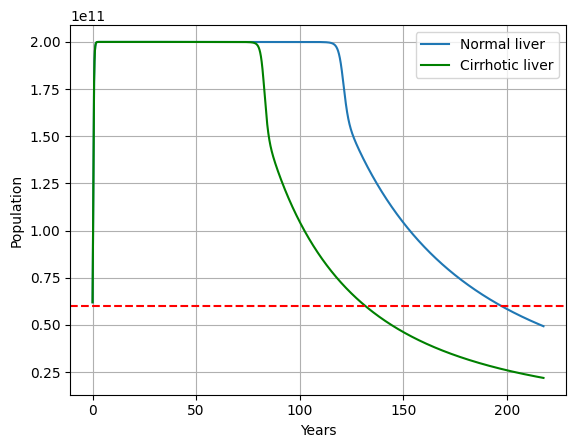

In [ ]:
plt.plot((t*21.5)/(365.25*24), solution2.y[0], label='Normal liver')
plt.plot((t*21.5)/(365.25*24), solution3.y[0], label='Cirrhotic liver', color = 'green')
#plt.plot(t, solution2.y[1], label='Stem cells')
#plt.plot(t, solution2.y[2], label='Mutated cells')
plt.xlabel('Years')
plt.ylabel('Population')
plt.axhline(0.3*K, ls = '--', color = 'r')
#if len(l) != 0:
    #plt.xlim(0, l[0])
plt.legend()
plt.grid('True')
plt.show()

$$
    aX + bY = \frac{d \hat X}{dt} = M \\
    M dt = d \hat X \\
    \frac{d X}{d t d \hat X} = \sigma \hat X \chi = \sigma \chi M t \\
    \frac{d^{2} X}{d t^{2} d \hat X} = \sigma \chi M \\
    \int \frac{d^{2} X}{d t^{2} d \hat X} d \hat X = \int \sigma \chi M d \hat X \\
    \frac{d^{2} X}{d t^{2}} = \int \sigma \chi M^{2} dt \\
    \frac{d^{2} X}{d t^{2}} = \sigma \chi M^{2} t + C_1\\
    \int \frac{d^{2} X}{d t^{2}} dt = \int (\sigma \chi M^{2} t + C_1)dt \\
    \frac{d X}{d t} = \frac{\sigma \chi M^{2} t^{2}}{2} + C_1t + C_2 = \mu \\
    \mu(t = 0) = 0 \\
    \frac{d \mu}{dt}(X = 0, Y = 0) = 0 \\
    C_1, C_2 = 0 \\
    \mu = \frac{\sigma \chi M^{2} t^{2}}{2}
$$

$$
    \frac{d X}{d t d \hat X} = \sigma \chi \hat X \\
    \frac{d X}{d t} = \sigma \chi \hat X d \hat X \\
    \frac{d X}{d t} = \sigma \chi \hat X M d t
$$

$$
    \frac{dX}{d \hat X} = \sigma \chi \hat X\\
    d X = \sigma \chi \hat X d \hat X \\
    \frac{d X}{d t} = \sigma \chi \hat X \frac{d \hat X}{d t} \\
    \frac{d X}{d t} = \sigma \chi \hat X M \\
    \frac{d X}{d t} = \sigma \chi M^{2} t
$$